In [1]:
import numpy as np
import pandas as pd
from util import (BOHR, read_mat, read_comp, get_iso, get_aniso, read_by_prompt, get_df_err, get_rmsre_3comp, get_relrmsd_3comp)
import itertools
import warnings
import basis_set_exchange as bse
from functools import partial

warnings.filterwarnings("ignore")
np.set_printoptions(8, suppress=True, linewidth=150)
pd.set_option('display.max_rows', None)
pd.set_option("display.precision", 3)
pd.set_option("float_format", '{:.3f}'.format)

In [2]:
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('svg')

In [3]:
def get_df_iso(df):
    xx, yy, zz = df["xx"], df["yy"], df["zz"]
    return 1 / 3 * (xx + yy + zz)

def get_df_aniso(df):
    xx, yy, zz, xy, yz, zx = df["xx"], df["yy"], df["zz"], df["xy"], df["yz"], df["zx"]
    return np.sqrt(0.5) * ((xx - yy)**2 + (yy - zz)**2 + (zz - xx)**2 + 6 * (xy**2 + yz**2 + zx**2))**0.5

## 读取基本数据

In [4]:
mol_hh101 = ['AlF', 'Ar', 'BF', 'BH2', 'BH2Cl', 'BH2F', 'BH3', 'BHF2', 'BeH', 'BeH2', 'C2H2', 'C2H4', 'CH2-t', 'CH2BH', 'CH2F', 'CH3', 'CH3BH2', 'CH3Cl', 'CH3F', 'CH3NH2', 'CH3OH', 'CH3SH', 'CH4', 'CO', 'CO2', 'CS', 'CSO', 'Cl2', 'ClCN', 'ClF', 'FCN', 'FCO', 'FH-OH', 'FNO', 'H', 'H2', 'H2CN', 'H2O', 'H2O-Li', 'HBO', 'HBS', 'HCCCl', 'HCCF', 'HCHO', 'HCHS', 'HCN', 'HCO', 'HCONH2', 'HCOOH', 'HCP', 'HCl', 'HF', 'HNC', 'HO2', 'HOCl', 'HOOH', 'He', 'Li', 'LiBH4', 'LiCN', 'LiCl', 'LiH', 'Mg', 'Mg2', 'N', 'N2', 'N2H2', 'N2H4', 'NH', 'NH2', 'NH2Cl', 'NH2F', 'NH2OH', 'NH3', 'NH3O', 'Na', 'NaCN', 'NaCl', 'NaH', 'Ne', 'OCl2', 'OF2', 'P', 'P2H4', 'PH', 'PH2', 'PH2OH', 'PH3', 'PH3O', 'S2', 'S2H2', 'SCl2', 'SF2', 'SH2', 'SO-trip', 'SO2', 'SiH3', 'SiH3Cl', 'SiH3F', 'SiH4', 'SiO']
mol_hh100 = mol_hh101.copy()
mol_hh100.remove("H")  # hydrogen removed

In [5]:
# B2PLYP convergence
df_conv = pd.read_csv("raw_data/conv_dh_B2PLYP.csv", index_col=[0, 1], header=[0, 1, 2])
# remove 1363 of T145
df_conv = df_conv.drop(("T145", "1363"))

In [6]:
# reference data
df_ref_hr46_iso = pd.read_csv("raw_data/HR46-ref-iso.csv", index_col=[0], header=[0])["CCSD(T)"]
df_ref_hr46_aniso = pd.read_csv("raw_data/HR46-ref-aniso.csv", index_col=[0], header=[0])["CCSD(T)"]
df_ref_t144_iso = pd.read_csv("raw_data/T144-ref-iso.csv", index_col=[0], header=[0])["CCSD(T)"]
df_ref_t144_aniso = pd.read_csv("raw_data/T144-ref-aniso.csv", index_col=[0], header=[0])["CCSD(T)"]
df_ref_t144_iso.index = df_conv.loc["T145"].index
df_ref_t144_aniso.index = df_conv.loc["T145"].index
df_ref_hh100_comp = pd.read_csv("raw_data/HH132-hait_ref.csv", index_col=[0], header=[0, 1]).loc[mol_hh100]["CCSD(T)"]

In [7]:
mask_hh100_sp = pd.read_csv("raw_data/HH132-hait_ref.csv", index_col=[0], header=[0, 1]).loc[mol_hh100][("Spin Polarization", "Spin Polarization")] == "SP"
mask_hr46_aniso = df_ref_hr46_aniso > 0.5
mask_t144_aniso = df_ref_t144_aniso > 0.5

In [8]:
columns = pd.MultiIndex.from_tuples([t[:2]  for t in df_conv.columns if t[-1] == "xx"])
df_conv_iso = pd.DataFrame(index=df_conv.index, columns=columns)
df_conv_aniso = pd.DataFrame(index=df_conv.index, columns=columns)
for basis, atr in columns:
    df_conv_iso.loc[:, (basis, atr)] = get_df_iso(df_conv[(basis, atr)])
    df_conv_aniso.loc[:, (basis, atr)] = get_df_aniso(df_conv[(basis, atr)])
# contribution of anisotropic is not linear
for basis, atr in columns:
    if atr != "pt2": continue
    df_conv_aniso.loc[:, (basis, "pt2")] = df_conv_aniso.loc[:, (basis, "tot")] - df_conv_aniso.loc[:, (basis, "low_rung")]

## aCV[Q5]Z CBS 参考值

In [9]:
df_hh100_cbs = df_conv.loc["HH118", ("aCV5Z", "low_rung")] + 1 / 61 * (125 * df_conv.loc["HH118", ("aCV5Z", "pt2")] - 64 * df_conv.loc["HH118", ("aCVQZ", "pt2")])
df_hh100_cbs = df_hh100_cbs.loc[mol_hh100]

In [10]:
df_hr46_iso = df_conv_iso.loc["HR46"].copy()
df_t144_iso = df_conv_iso.loc["T145"].copy()
df_hr46_aniso = df_conv_aniso.loc["HR46"].copy()
df_t144_aniso = df_conv_aniso.loc["T145"].copy()
df_hh100_iso = df_conv_iso.loc["HH118"].loc[mol_hh100].copy()
df_hh100_comp = df_conv.loc["HH118"].loc[mol_hh100].copy()

In [11]:
for cbs_scheme, cbs_1, cbs_2, coef_1, coef_2 in [
    ("aCV[DT]Z", "aCVDZ", "aCVTZ", - 8 / 19,  27 / 19),
    ("aCV[TQ]Z", "aCVTZ", "aCVQZ", -27 / 37,  64 / 37),
    ("aCV[Q5]Z", "aCVQZ", "aCV5Z", -64 / 61, 125 / 61),
    ("apc[12]" , "apc1" , "apc2" , - 8 / 19,  27 / 19),
    ("apc[23]" , "apc2" , "apc3" , -27 / 37,  64 / 37),
    ("apc[34]" , "apc3" , "apc4" , -64 / 61, 125 / 61),
]:
    for df in [df_hr46_iso, df_t144_iso, df_hr46_aniso, df_t144_aniso, df_hh100_iso]:
        df.loc[:, (cbs_scheme, "low_rung")] = df.loc[:, (cbs_2, "low_rung")]
        df.loc[:, (cbs_scheme, "pt2")] = coef_1 * df.loc[:, (cbs_1, "pt2")] + coef_2 * df.loc[:, (cbs_2, "pt2")]
        df.loc[:, (cbs_scheme, "tot")] = df.loc[:, (cbs_scheme, "low_rung")] + df.loc[:, (cbs_scheme, "pt2")]
    df = df_hh100_comp
    for ts in ["xx", "yy", "zz", "xy", "yz", "zx"]:
        df.loc[:, (cbs_scheme, "low_rung", ts)] = df.loc[:, (cbs_2, "low_rung", ts)]
        df.loc[:, (cbs_scheme, "pt2", ts)] = coef_1 * df.loc[:, (cbs_1, "pt2", ts)] + coef_2 * df.loc[:, (cbs_2, "pt2", ts)]
        df.loc[:, (cbs_scheme, "tot", ts)] = df.loc[:, (cbs_scheme, "low_rung", ts)] + df.loc[:, (cbs_scheme, "pt2", ts)]

In [12]:
scheme_list = [
    "aCVDZ", "apc1",
    "aCVTZ", "apc2", "aCV[DT]Z", "apc[12]",
    "aCVQZ", "apc3", "aCV[TQ]Z", "apc[23]",
    "aCV5Z", "apc4", "aCV[Q5]Z", "apc[34]"]
dataset_list = ["HH101 (NSP)", "HH101 (SP)", "HR46", "T144"]
comp_list = ["low_rung", "pt2", "tot"]

In [13]:
df_iso_err = pd.DataFrame(index=scheme_list, columns=pd.MultiIndex.from_product([dataset_list, comp_list]))
for scheme in scheme_list:
    for comp in comp_list:
        if "[" in scheme and comp == "low_rung": continue
        df_iso_err.loc[scheme, ("HR46", comp)] = get_df_err(
            df_hr46_iso[(scheme, comp)],
            df_hr46_iso[("aCV[Q5]Z", comp)],
            df_hr46_iso[("aCV[Q5]Z", "tot")])["RelRMSD/%"]
        df_iso_err.loc[scheme, ("T144", comp)] = get_df_err(
            df_t144_iso[(scheme, comp)],
            df_t144_iso[("aCV[Q5]Z", comp)],
            df_t144_iso[("aCV[Q5]Z", "tot")])["RelRMSD/%"]
        df_iso_err.loc[scheme, ("HH101 (NSP)", comp)] = get_df_err(
            df_hh100_iso.loc[~mask_hh100_sp, (scheme, comp)],
            df_hh100_iso.loc[~mask_hh100_sp, ("aCV[Q5]Z", comp)],
            df_hh100_iso.loc[~mask_hh100_sp, ("aCV[Q5]Z", "tot")])["RelRMSD/%"]
        df_iso_err.loc[scheme, ("HH101 (SP)", comp)] = get_df_err(
            df_hh100_iso.loc[mask_hh100_sp, (scheme, comp)],
            df_hh100_iso.loc[mask_hh100_sp, ("aCV[Q5]Z", comp)],
            df_hh100_iso.loc[mask_hh100_sp, ("aCV[Q5]Z", "tot")])["RelRMSD/%"]

In [14]:
df_iso_err[["HR46", "T144"]].fillna("")

HR46                 T144            
         low_rung   pt2   tot low_rung   pt2   tot
aCVDZ       2.428 0.250 2.528    1.560 0.185 1.448
apc1        1.001 0.188 0.905    0.855 0.225 0.686
aCVTZ       0.542 0.120 0.571    0.241 0.134 0.152
apc2        0.262 0.144 0.187    0.222 0.166 0.099
aCV[DT]Z          0.111 0.532          0.124 0.146
apc[12]           0.153 0.224          0.150 0.114
aCVQZ       0.086 0.069 0.121    0.018 0.082 0.073
apc3        0.067 0.061 0.120    0.029 0.078 0.104
aCV[TQ]Z          0.057 0.096          0.049 0.041
apc[23]           0.029 0.073          0.019 0.044
aCV5Z       0.000 0.036 0.036    0.000 0.042 0.042
apc4        0.099 0.046 0.140    0.050 0.054 0.102
aCV[Q5]Z          0.000 0.000          0.000 0.000
apc[34]           0.034 0.127          0.032 0.080

In [15]:
df_iso_err[["HH101 (NSP)", "HH101 (SP)"]].fillna("")

HH101 (NSP)             HH101 (SP)            
            low_rung   pt2   tot   low_rung   pt2   tot
aCVDZ          4.521 0.563 4.886      3.718 0.748 4.026
apc1           1.783 0.882 1.990      1.639 0.946 1.798
aCVTZ          1.337 0.290 1.542      0.864 0.325 1.003
apc2           0.508 0.335 0.449      0.621 0.620 0.693
aCV[DT]Z             0.215 1.444            0.213 0.914
apc[12]              0.550 0.577            0.501 0.605
aCVQZ          0.296 0.148 0.423      0.146 0.204 0.282
apc3           0.194 0.109 0.246      0.167 0.144 0.189
aCV[TQ]Z             0.069 0.337            0.161 0.218
apc[23]              0.257 0.328            0.224 0.345
aCV5Z          0.000 0.076 0.076      0.000 0.105 0.105
apc4           0.214 0.075 0.255      0.135 0.112 0.190
aCV[Q5]Z             0.000 0.000            0.000 0.000
apc[34]              0.154 0.282            0.094 0.177

In [16]:
df_aniso_err = pd.DataFrame(index=scheme_list, columns=pd.MultiIndex.from_product([["HR46", "T144"], comp_list]))
for scheme in scheme_list:
    for comp in comp_list:
        if "[" in scheme and comp == "low_rung": continue
        df_aniso_err.loc[scheme, ("HR46", comp)] = get_df_err(
            df_hr46_aniso.loc[mask_hr46_aniso, (scheme, comp)],
            df_hr46_aniso.loc[mask_hr46_aniso, ("aCV[Q5]Z", comp)],
            df_hr46_aniso.loc[mask_hr46_aniso, ("aCV[TQ]Z", "tot")])["RelRMSD/%"]
        df_aniso_err.loc[scheme, ("T144", comp)] = get_df_err(
            df_t144_aniso.loc[mask_t144_aniso, (scheme, comp)],
            df_t144_aniso.loc[mask_t144_aniso, ("aCV[Q5]Z", comp)],
            df_t144_aniso.loc[mask_t144_aniso, ("aCV[TQ]Z", "tot")])["RelRMSD/%"]

In [17]:
df_aniso_err.fillna("")

HR46                 T144            
         low_rung   pt2   tot low_rung   pt2   tot
aCVDZ       3.389 0.505 3.596    1.742 0.264 1.860
apc1        2.271 0.892 2.885    1.321 0.446 1.530
aCVTZ       0.777 0.122 0.845    0.313 0.090 0.374
apc2        0.342 0.311 0.503    0.159 0.145 0.201
aCV[DT]Z          0.230 0.845          0.137 0.383
apc[12]           0.130 0.351          0.103 0.170
aCVQZ       0.140 0.073 0.196    0.053 0.059 0.090
apc3        0.102 0.124 0.174    0.061 0.058 0.085
aCV[TQ]Z          0.058 0.183          0.043 0.079
apc[23]           0.099 0.115          0.050 0.055
aCV5Z       0.000 0.038 0.038    0.000 0.030 0.030
apc4        0.108 0.053 0.130    0.061 0.038 0.073
aCV[Q5]Z          0.000 0.000          0.000 0.000
apc[34]           0.041 0.122          0.037 0.071

In [18]:
df_comp_err = pd.DataFrame(index=scheme_list, columns=pd.MultiIndex.from_product([["HH101 (NSP)", "HH101 (SP)"], comp_list]))
for scheme in scheme_list:
    for comp in comp_list:
        if "[" in scheme and comp == "low_rung": continue
        df_comp_err.loc[scheme, ("HH101 (NSP)", comp)] = get_relrmsd_3comp(get_df_err(
            df_hh100_comp.loc[~mask_hh100_sp, (scheme, comp)],
            df_hh100_comp.loc[~mask_hh100_sp, ("aCV[Q5]Z", comp)],
            df_hh100_comp.loc[~mask_hh100_sp, ("aCV[TQ]Z", "tot")])[["xx", "yy", "zz"]])
        df_comp_err.loc[scheme, ("HH101 (SP)", comp)] = get_relrmsd_3comp(get_df_err(
            df_hh100_comp.loc[mask_hh100_sp, (scheme, comp)],
            df_hh100_comp.loc[mask_hh100_sp, ("aCV[Q5]Z", comp)],
            df_hh100_comp.loc[mask_hh100_sp, ("aCV[TQ]Z", "tot")])[["xx", "yy", "zz"]])

In [19]:
df_comp_err.fillna("")

HH101 (NSP)             HH101 (SP)            
            low_rung   pt2   tot   low_rung   pt2   tot
aCVDZ          4.990 0.619 5.390      4.276 0.815 4.673
apc1           2.069 0.900 2.278      1.804 0.962 1.934
aCVTZ          1.455 0.324 1.690      1.019 0.364 1.211
apc2           0.607 0.349 0.561      0.656 0.628 0.712
aCV[DT]Z             0.240 1.584            0.240 1.104
apc[12]              0.560 0.674            0.516 0.632
aCVQZ          0.323 0.166 0.468      0.181 0.218 0.331
apc3           0.214 0.181 0.302      0.182 0.146 0.202
aCV[TQ]Z             0.077 0.370            0.163 0.250
apc[23]              0.343 0.410            0.231 0.354
aCV5Z          0.000 0.085 0.085      0.000 0.112 0.112
apc4           0.238 0.078 0.279      0.160 0.114 0.210
aCV[Q5]Z             0.000 0.000            0.000 0.000
apc[34]              0.214 0.335            0.097 0.199

## apc[34] CBS 参考值

In [20]:
df_iso_apc34_err = pd.DataFrame(index=scheme_list, columns=pd.MultiIndex.from_product([dataset_list, comp_list]))
for scheme in scheme_list:
    for comp in comp_list:
        if "[" in scheme and comp == "low_rung": continue
        df_iso_apc34_err.loc[scheme, ("HR46", comp)] = get_df_err(
            df_hr46_iso[(scheme, comp)],
            df_hr46_iso[("apc[34]", comp)],
            df_hr46_iso[("apc[34]", "tot")])["RelRMSD/%"]
        df_iso_apc34_err.loc[scheme, ("T144", comp)] = get_df_err(
            df_t144_iso[(scheme, comp)],
            df_t144_iso[("apc[34]", comp)],
            df_t144_iso[("apc[34]", "tot")])["RelRMSD/%"]
        df_iso_apc34_err.loc[scheme, ("HH101 (NSP)", comp)] = get_df_err(
            df_hh100_iso.loc[~mask_hh100_sp, (scheme, comp)],
            df_hh100_iso.loc[~mask_hh100_sp, ("apc[34]", comp)],
            df_hh100_iso.loc[~mask_hh100_sp, ("apc[34]", "tot")])["RelRMSD/%"]
        df_iso_apc34_err.loc[scheme, ("HH101 (SP)", comp)] = get_df_err(
            df_hh100_iso.loc[mask_hh100_sp, (scheme, comp)],
            df_hh100_iso.loc[mask_hh100_sp, ("apc[34]", comp)],
            df_hh100_iso.loc[mask_hh100_sp, ("apc[34]", "tot")])["RelRMSD/%"]

In [21]:
df_iso_apc34_err[["HR46", "T144"]].fillna("")

HR46                 T144            
         low_rung   pt2   tot low_rung   pt2   tot
aCVDZ       2.515 0.260 2.640    1.605 0.168 1.520
apc1        1.051 0.177 0.970    0.895 0.203 0.746
aCVTZ       0.633 0.114 0.677    0.289 0.108 0.215
apc2        0.335 0.120 0.250    0.265 0.138 0.143
aCV[DT]Z          0.089 0.635          0.096 0.212
apc[12]           0.127 0.273          0.120 0.159
aCVQZ       0.163 0.053 0.184    0.061 0.055 0.037
apc3        0.041 0.039 0.035    0.024 0.050 0.032
aCV[TQ]Z          0.030 0.156          0.021 0.048
apc[23]           0.038 0.075          0.020 0.042
aCV5Z       0.099 0.028 0.117    0.050 0.018 0.046
apc4        0.000 0.020 0.020    0.000 0.025 0.025
aCV[Q5]Z          0.034 0.126          0.032 0.080
apc[34]           0.000 0.000          0.000 0.000

In [22]:
df_iso_apc34_err[["HH101 (NSP)", "HH101 (SP)"]].fillna("")

HH101 (NSP)             HH101 (SP)            
            low_rung   pt2   tot   low_rung   pt2   tot
aCVDZ          4.696 0.588 5.089      3.830 0.710 4.149
apc1           1.876 0.887 2.128      1.690 0.891 1.820
aCVTZ          1.531 0.301 1.746      0.980 0.268 1.116
apc2           0.577 0.345 0.535      0.696 0.564 0.717
aCV[DT]Z             0.207 1.646            0.143 1.026
apc[12]              0.555 0.626            0.446 0.634
aCVQZ          0.469 0.185 0.594      0.257 0.129 0.334
apc3           0.074 0.218 0.222      0.159 0.095 0.145
aCV[TQ]Z             0.145 0.509            0.083 0.261
apc[23]              0.348 0.384            0.278 0.379
aCV5Z          0.213 0.154 0.305      0.135 0.049 0.170
apc4           0.000 0.111 0.111      0.000 0.049 0.049
aCV[Q5]Z             0.153 0.280            0.094 0.176
apc[34]              0.000 0.000            0.000 0.000

In [61]:
df_aniso_apc34_err = pd.DataFrame(index=scheme_list, columns=pd.MultiIndex.from_product([["HR46", "T144"], comp_list]))
for scheme in scheme_list:
    for comp in comp_list:
        if "[" in scheme and comp == "low_rung": continue
        df_aniso_apc34_err.loc[scheme, ("HR46", comp)] = get_df_err(
            df_hr46_aniso.loc[mask_hr46_aniso, (scheme, comp)],
            df_hr46_aniso.loc[mask_hr46_aniso, ("apc[34]", comp)],
            df_hr46_aniso.loc[mask_hr46_aniso, ("apc[34]", "tot")])["RelRMSD/%"]
        df_aniso_apc34_err.loc[scheme, ("T144", comp)] = get_df_err(
            df_t144_aniso.loc[mask_t144_aniso, (scheme, comp)],
            df_t144_aniso.loc[mask_t144_aniso, ("apc[34]", comp)],
            df_t144_aniso.loc[mask_t144_aniso, ("apc[34]", "tot")])["RelRMSD/%"]

In [63]:
df_aniso_apc34_err.fillna("")

HR46                 T144            
         low_rung   pt2   tot low_rung   pt2   tot
aCVDZ       3.488 0.531 3.710    1.796 0.275 1.915
apc1        2.288 0.923 2.920    1.322 0.460 1.550
aCVTZ       0.869 0.129 0.950    0.367 0.074 0.420
apc2        0.420 0.339 0.568    0.182 0.153 0.228
aCV[DT]Z          0.210 0.949          0.111 0.421
apc[12]           0.140 0.430          0.094 0.186
aCVQZ       0.235 0.079 0.293    0.079 0.040 0.105
apc3        0.046 0.152 0.167    0.018 0.061 0.070
aCV[TQ]Z          0.061 0.276          0.024 0.090
apc[23]           0.103 0.129          0.038 0.044
aCV5Z       0.109 0.052 0.145    0.061 0.025 0.076
apc4        0.000 0.078 0.078    0.000 0.031 0.031
aCV[Q5]Z          0.041 0.122          0.037 0.071
apc[34]           0.000 0.000          0.000 0.000

In [72]:
df_comp_apc34_err = pd.DataFrame(index=scheme_list, columns=pd.MultiIndex.from_product([["HH101 (NSP)", "HH101 (SP)"], comp_list]))
for scheme in scheme_list:
    for comp in comp_list:
        if "[" in scheme and comp == "low_rung": continue
        df_comp_apc34_err.loc[scheme, ("HH101 (NSP)", comp)] = get_relrmsd_3comp(get_df_err(
            df_hh100_comp.loc[~mask_hh100_sp, (scheme, comp)],
            df_hh100_comp.loc[~mask_hh100_sp, ("apc[34]", comp)],
            df_hh100_comp.loc[~mask_hh100_sp, ("apc[34]", "tot")])[["xx", "yy", "zz"]])
        df_comp_apc34_err.loc[scheme, ("HH101 (SP)", comp)] = get_relrmsd_3comp(get_df_err(
            df_hh100_comp.loc[mask_hh100_sp, (scheme, comp)],
            df_hh100_comp.loc[mask_hh100_sp, ("apc[34]", comp)],
            df_hh100_comp.loc[mask_hh100_sp, ("apc[34]", "tot")])[["xx", "yy", "zz"]])

In [73]:
df_comp_apc34_err.fillna("")

HH101 (NSP)             HH101 (SP)            
            low_rung   pt2   tot   low_rung   pt2   tot
aCVDZ          5.135 0.646 5.546      4.397 0.780 4.805
apc1           2.162 0.910 2.398      1.855 0.912 1.960
aCVTZ          1.646 0.358 1.884      1.154 0.312 1.341
apc2           0.682 0.396 0.659      0.742 0.574 0.747
aCV[DT]Z             0.272 1.778            0.177 1.234
apc[12]              0.595 0.741            0.463 0.668
aCVQZ          0.507 0.246 0.663      0.311 0.148 0.411
apc3           0.081 0.353 0.355      0.165 0.101 0.153
aCV[TQ]Z             0.212 0.572            0.086 0.321
apc[23]              0.499 0.524            0.286 0.392
aCV5Z          0.234 0.214 0.360      0.159 0.063 0.206
apc4           0.000 0.181 0.181      0.000 0.052 0.052
aCV[Q5]Z             0.209 0.329            0.097 0.199
apc[34]              0.000 0.000            0.000 0.000

## Analysis

In [23]:
mask_cur = (~mask_hh100_sp).copy()
mask_cur["Ne"] = False
mask_cur["Ar"] = False
mask_cur["NH3O"] = False
mask_cur["HF"] = False

In [24]:
get_df_err(
    df_hh100_iso.loc[mask_cur, ("apc3", "low_rung")],
    df_hh100_iso.loc[mask_cur, ("aCV[Q5]Z", "low_rung")],
    df_hh100_iso.loc[mask_cur, ("aCV[Q5]Z", "tot")])

MaxE/A^3    0.060
MAD/A^3     0.003
RMSD/A^3    0.009
RelMaxE/%   0.320
RelMAD/%    0.066
RelRMSD/%   0.103
dtype: float64

In [25]:
err = 100 * (df_hh100_iso.loc[:, ("apc3", "low_rung")] - df_hh100_iso.loc[:, ("aCV[Q5]Z", "low_rung")]) / df_hh100_iso.loc[:, ("aCV[Q5]Z", "tot")]
err = err[~mask_hh100_sp]
err[err.abs() > 0.3]

Ar     0.466
HCl    0.320
HF     0.637
NH3O   0.409
Ne     1.118
dtype: object

In [26]:
err = 100 * (df_hh100_iso.loc[:, ("apc4", "low_rung")] - df_hh100_iso.loc[:, ("aCV[Q5]Z", "low_rung")]) / df_hh100_iso.loc[:, ("aCV[Q5]Z", "tot")]
err = err[~mask_hh100_sp]
err[err.abs() > 0.4]

Ar     0.519
HCl    0.448
HF     0.675
NH3O   0.472
Ne     1.094
dtype: object

In [81]:
err = 100 * (df_hh100_iso.loc[:, ("apc3", "pt2")] - df_hh100_iso.loc[:, ("apc[34]", "pt2")]) / df_hh100_iso.loc[:, ("apc[34]", "tot")]
err = err[~mask_hh100_sp]
print(err[err.abs() > 0.3])

mask_cur = (~mask_hh100_sp).copy()
mask_cur["NaCl"] = False

print(get_df_err(
    df_hh100_iso.loc[mask_cur, ("apc3", "pt2")],
    df_hh100_iso.loc[mask_cur, ("apc[34]", "pt2")],
    df_hh100_iso.loc[mask_cur, ("apc[34]", "tot")]))

LiCl    0.381
Mg      0.557
NaCl   -1.660
dtype: object
MaxE/A^3    0.059
MAD/A^3     0.003
RMSD/A^3    0.008
RelMaxE/%   0.557
RelMAD/%    0.065
RelRMSD/%   0.102
dtype: float64


In [102]:
err = 100 * (df_hh100_iso.loc[:, ("apc3", "low_rung")] - df_hh100_iso.loc[:, ("apc[34]", "low_rung")]) / df_hh100_iso.loc[:, ("apc[34]", "tot")]
err = err[mask_hh100_sp]
print(err[err.abs() > 0.3])

mask_cur = (mask_hh100_sp).copy()
mask_cur["P"] = False

print(get_df_err(
    df_hh100_iso.loc[mask_cur, ("apc3", "low_rung")],
    df_hh100_iso.loc[mask_cur, ("apc[34]", "low_rung")],
    df_hh100_iso.loc[mask_cur, ("apc[34]", "tot")]))

P   -0.615
dtype: object
MaxE/A^3    0.070
MAD/A^3     0.008
RMSD/A^3    0.017
RelMaxE/%   0.237
RelMAD/%    0.086
RelRMSD/%   0.105
dtype: float64


In [80]:
err = 100 * (df_hr46_aniso.loc[mask_hr46_aniso, ("apc3", "pt2")] - df_hr46_aniso.loc[mask_hr46_aniso, ("apc[34]", "pt2")]) / df_hr46_aniso.loc[mask_hr46_aniso, ("apc[34]", "tot")]
print(err[err.abs() > 0.3])

mask_cur = mask_hr46_aniso.copy()
mask_cur["trimethyl_amine"] = False

print(get_df_err(
    df_hr46_aniso.loc[mask_cur, ("apc3", "pt2")],
    df_hr46_aniso.loc[mask_cur, ("apc[34]", "pt2")],
    df_hr46_aniso.loc[mask_cur, ("apc[34]", "tot")]))

trimethyl_amine   -0.622
dtype: object
MaxE/A^3    0.006
MAD/A^3     0.002
RMSD/A^3    0.003
RelMaxE/%   0.264
RelMAD/%    0.098
RelRMSD/%   0.117
dtype: float64


In [86]:
mask_cur = (~mask_hh100_sp).copy()
mask_cur["NaCl"] = False

get_relrmsd_3comp(get_df_err(
        df_hh100_comp.loc[mask_cur, ("apc3", "pt2")],
        df_hh100_comp.loc[mask_cur, ("apc[34]", "pt2")],
        df_hh100_comp.loc[mask_cur, ("apc[34]", "tot")])[["xx", "yy", "zz"]])

0.11033735123691149

In [103]:
mask_cur = (mask_hh100_sp).copy()
mask_cur["P"] = False

get_relrmsd_3comp(get_df_err(
        df_hh100_comp.loc[mask_cur, ("apc3", "pt2")],
        df_hh100_comp.loc[mask_cur, ("apc[34]", "pt2")],
        df_hh100_comp.loc[mask_cur, ("apc[34]", "tot")])[["xx", "yy", "zz"]])

0.102543825960781

## Plot of basis

In [27]:
def basis_mask(basis, elem):
    # basic information
    shells = bse.get_basis(basis, elements=elem)["elements"][elem]["electron_shells"]
    expos = [np.array(d["exponents"], dtype=float) for d in shells]
    coefs = [np.array(d["coefficients"], dtype=float) for d in shells]
    masks = [np.zeros_like(expo, dtype=bool) for expo in expos]
    angs = [d["angular_momentum"] for d in shells]
    angs = np.array(angs).flatten()
    # generate mask for primitive and contracted
    for i, coef in enumerate(coefs):
        for j, c in enumerate(coef):
            m = np.abs(c - 1) < 1e-14
            masks[i] |= m
    # merge by angular moments
    expos_ = [np.array([], dtype=float) for _ in range(angs.max() + 1)]
    masks_ = [np.array([], dtype=bool) for _ in range(angs.max() + 1)]
    for ang, expo, mask in zip(angs, expos, masks):
        expos_[ang] = np.concatenate([expos_[ang], expo])
        masks_[ang] = np.concatenate([masks_[ang], mask])
    return expos_, masks_

In [28]:
expos, masks = basis_mask("aug-pc-3", "6")

In [29]:
def plot_expo(ax, expos, masks, color, linewidth=1, **kwargs):
    ang_max = len(expos)
    for ang, expo, mask in zip(range(ang_max), expos, masks):
        for e, m in zip(expo, mask):
            ax.plot([e, e], [ang - linewidth / 2, ang + linewidth / 2], linestyle=("-" if m else "--"), color=color, **kwargs)
    return ax

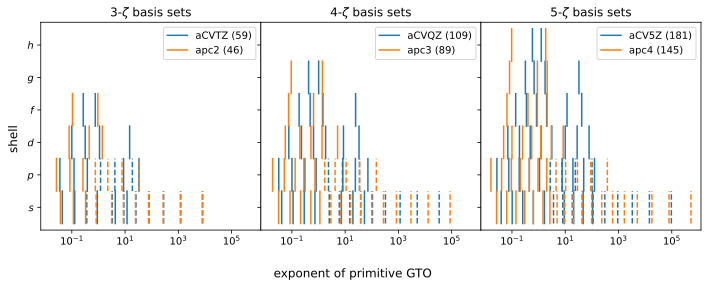

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={"wspace": 0}, sharey=True, sharex=True)

expos, masks = basis_mask("aug-cc-pCVTZ", "6")
plot_expo(axs[0], expos, masks, "C0")
expos, masks = basis_mask("aug-pc-2", "6")
plot_expo(axs[0], expos, masks, "C1")

expos, masks = basis_mask("aug-cc-pCVQZ", "6")
plot_expo(axs[1], expos, masks, "C0")
expos, masks = basis_mask("aug-pc-3", "6")
plot_expo(axs[1], expos, masks, "C1")

expos, masks = basis_mask("aug-cc-pCV5Z", "6")
plot_expo(axs[2], expos, masks, "C0")
expos, masks = basis_mask("aug-pc-4", "6")
plot_expo(axs[2], expos, masks, "C1")

axs[0].set_xscale("log")
axs[0].set_yticks([0, 1, 2, 3, 4, 5])
axs[0].set_yticklabels(["$s$", "$p$", "$d$", "$f$", "$g$", "$h$"])
axs[0].set_title("3-$\zeta$ basis sets")
axs[1].set_title("4-$\zeta$ basis sets")
axs[2].set_title("5-$\zeta$ basis sets")

axs[0].set_ylim(-0.7, 5.7)
axs[0].plot([1, 1], [-10, -10], color="C0", label="aCVTZ (59)")
axs[0].plot([1, 1], [-10, -10], color="C1", label="apc2 (46)")
axs[1].plot([1, 1], [-10, -10], color="C0", label="aCVQZ (109)")
axs[1].plot([1, 1], [-10, -10], color="C1", label="apc3 (89)")
axs[2].plot([1, 1], [-10, -10], color="C0", label="aCV5Z (181)")
axs[2].plot([1, 1], [-10, -10], color="C1", label="apc4 (145)")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.supylabel("shell")
fig.supxlabel("exponent of primitive GTO")
fig.tight_layout()
fig.savefig("../basis_exponent_plot.pdf", transparent=True)

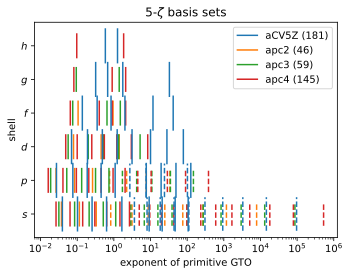

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), gridspec_kw={"wspace": 0}, sharey=True, sharex=True)

expos, masks = basis_mask("aug-cc-pCV5Z", "6")
plot_expo(ax, expos, masks, "C0", zorder=10)
expos, masks = basis_mask("aug-pc-2", "6")
plot_expo(ax, expos, masks, "C1", linewidth=0.7)
expos, masks = basis_mask("aug-pc-3", "6")
plot_expo(ax, expos, masks, "C2", linewidth=0.7)
expos, masks = basis_mask("aug-pc-4", "6")
plot_expo(ax, expos, masks, "C3", linewidth=0.7)

ax.set_xscale("log")
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_yticklabels(["$s$", "$p$", "$d$", "$f$", "$g$", "$h$"])
ax.set_title("3-$\zeta$ basis sets")
ax.set_title("4-$\zeta$ basis sets")
ax.set_title("5-$\zeta$ basis sets")

ax.set_ylim(-0.7, 5.7)
ax.plot([1, 1], [-10, -10], color="C0", label="aCV5Z (181)")
ax.plot([1, 1], [-10, -10], color="C1", label="apc2 (46)")
ax.plot([1, 1], [-10, -10], color="C2", label="apc3 (59)")
ax.plot([1, 1], [-10, -10], color="C3", label="apc4 (145)")
ax.legend()
ax.set_ylabel("shell")
ax.set_xlabel("exponent of primitive GTO")
fig.tight_layout()
fig.savefig("../basis_exponent_plot_compare.pdf", transparent=True)

## Error plot of relative error

In [32]:
def symlog_scale(x):
    # "symlog", linthresh=1e-2, linscale=0.25
    if x >= 1e-2:
        return np.log10(x) + 2 + 0.25
    elif x <= - 1e-2:
        return - np.log10(-x) - 2 - 0.25
    else:
        return x / 1e-2 * 0.25
symlog_scale = np.vectorize(symlog_scale)

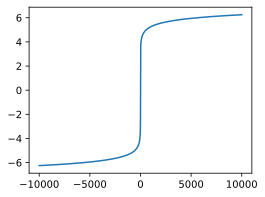

In [33]:
fig, ax = plt.subplots(figsize=(4, 3))

xs = np.concatenate([- 10**np.linspace(4, -4, 100), 10**np.linspace(-4, 4, 100)])
ax.plot(xs, symlog_scale(xs))

In [34]:
# Error compared to aCV[Q5]Z

df_hr46_iso_err_dunning = df_hr46_iso.copy().astype(float)
df_t144_iso_err_dunning = df_t144_iso.copy().astype(float)
df_hh100_iso_err_dunning = df_hh100_iso.copy().astype(float)

for d_err, d in zip([df_hr46_iso_err_dunning, df_t144_iso_err_dunning, df_hh100_iso_err_dunning], [df_hr46_iso, df_t144_iso, df_hh100_iso]):
    for basis in df_hr46_iso.columns.levels[0]:
        for task in ["low_rung", "pt2", "tot"]:
            d_err.loc[:, (basis, task)] = (d.loc[:, (basis, task)] - d.loc[:, ("aCV[Q5]Z", task)]) / d.loc[:, ("aCV[Q5]Z", "tot")] * 100

# Error compared to apc[34]

df_hr46_iso_err_jensen = df_hr46_iso.copy().astype(float)
df_t144_iso_err_jensen = df_t144_iso.copy().astype(float)
df_hh100_iso_err_jensen = df_hh100_iso.copy().astype(float)

for d_err, d in zip([df_hr46_iso_err_jensen, df_t144_iso_err_jensen, df_hh100_iso_err_jensen], [df_hr46_iso, df_t144_iso, df_hh100_iso]):
    for basis in df_hr46_iso.columns.levels[0]:
        for task in ["low_rung", "pt2", "tot"]:
            d_err.loc[:, (basis, task)] = (d.loc[:, (basis, task)] - d.loc[:, ("apc[34]", task)]) / d.loc[:, ("apc[34]", "tot")] * 100

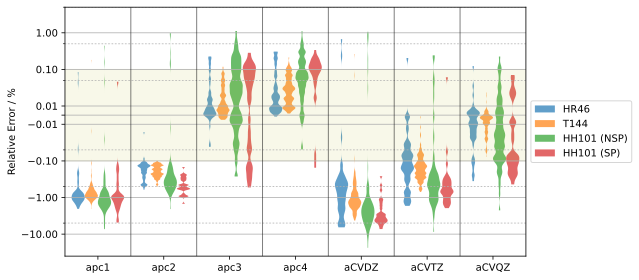

In [35]:
fig, ax = plt.subplots(1, figsize=(9, 4), gridspec_kw={"wspace": 0}, sharey=True)

# plot

basis_list = ["apc1", "apc2", "apc3", "apc4", "aCVDZ", "aCVTZ", "aCVQZ"]
parts = [None] * 7
parts[0] = ax.violinplot([symlog_scale(df_hr46_iso_err_dunning[(basis, "low_rung")]) for basis in basis_list],
                         positions=np.arange(7) - 0.3, bw_method=0.1, widths=0.2, showextrema=False)
parts[1] = ax.violinplot([symlog_scale(df_t144_iso_err_dunning[(basis, "low_rung")]) for basis in basis_list],
                         positions=np.arange(7) - 0.1, bw_method=0.1, widths=0.2, showextrema=False)
parts[2] = ax.violinplot([symlog_scale(df_hh100_iso_err_dunning.loc[~mask_hh100_sp, (basis, "low_rung")]) for basis in basis_list],
                         positions=np.arange(7) + 0.1, bw_method=0.1, widths=0.2, showextrema=False)
parts[3] = ax.violinplot([symlog_scale(df_hh100_iso_err_dunning.loc[mask_hh100_sp, (basis, "low_rung")]) for basis in basis_list],
                         positions=np.arange(7) + 0.3, bw_method=0.1, widths=0.2, showextrema=False)

# === configurations

for part, color in zip(parts, ["C0", "C1", "C2", "C3"]):
    for p in part["bodies"]:
        p.set_facecolor(color); p.set_alpha(0.7)

ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.arange(7))
ax.set_xticklabels(["apc1", "apc2", "apc3", "apc4", "aCVDZ", "aCVTZ", "aCVQZ"])

ax.set_ylim(symlog_scale(-40), symlog_scale(3))
ax.set_yticks(symlog_scale(np.array([-10, -1, -1e-1, -1e-2, 0, 1e-2, 1e-1, 1])))
ax.set_yticks(symlog_scale(np.array([-5, -0.5, -0.05, 0.05, 0.5, 5])), minor=True)
ax.set_yticklabels(["$-10.00$", "$-1.00$", "$-0.10$", "$-0.01$", " ", "$0.01$", "$0.10$", "$1.00$"])
ax.grid(axis="y")
ax.grid(axis="y", which="minor", dashes=(1.5, 0.5, 0.1))
ax.fill_between([-10, 100], symlog_scale([-0.1, -0.1]), symlog_scale([0.1, 0.1]), color="C8", alpha=0.1)

ax.set_ylabel("Relative Error / %")

for i in range(6):
    ax.plot([i+0.5, i+0.5], [-10, 10], color="black", alpha=0.5, linewidth=1)

parts[0]["bodies"][0].set_label("HR46")
parts[1]["bodies"][0].set_label("T144")
parts[2]["bodies"][0].set_label("HH101 (NSP)")
parts[3]["bodies"][0].set_label("HH101 (SP)")
ax.legend(loc="center left", bbox_to_anchor=(1.00, 0.5))
fig.tight_layout()
fig.savefig("../converg-b2p-scf-aCV5Z.pdf", transparent=True)

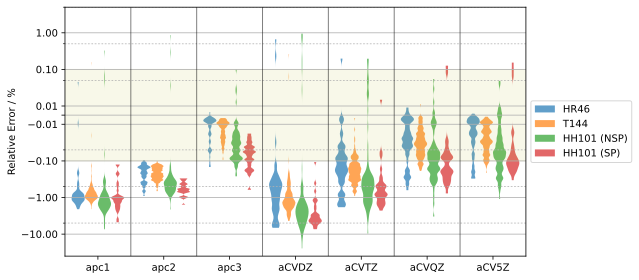

In [36]:
fig, ax = plt.subplots(1, figsize=(9, 4), gridspec_kw={"wspace": 0}, sharey=True)

# plot

basis_list = ["apc1", "apc2", "apc3", "aCVDZ", "aCVTZ", "aCVQZ", "aCV5Z"]
parts = [None] * 7
parts[0] = ax.violinplot([symlog_scale(df_hr46_iso_err_jensen[(basis, "low_rung")]) for basis in basis_list],
                         positions=np.arange(7) - 0.3, bw_method=0.1, widths=0.2, showextrema=False)
parts[1] = ax.violinplot([symlog_scale(df_t144_iso_err_jensen[(basis, "low_rung")]) for basis in basis_list],
                         positions=np.arange(7) - 0.1, bw_method=0.1, widths=0.2, showextrema=False)
parts[2] = ax.violinplot([symlog_scale(df_hh100_iso_err_jensen.loc[~mask_hh100_sp, (basis, "low_rung")]) for basis in basis_list],
                         positions=np.arange(7) + 0.1, bw_method=0.1, widths=0.2, showextrema=False)
parts[3] = ax.violinplot([symlog_scale(df_hh100_iso_err_jensen.loc[mask_hh100_sp, (basis, "low_rung")]) for basis in basis_list],
                         positions=np.arange(7) + 0.3, bw_method=0.1, widths=0.2, showextrema=False)

# === configurations

for part, color in zip(parts, ["C0", "C1", "C2", "C3"]):
    for p in part["bodies"]:
        p.set_facecolor(color); p.set_alpha(0.7)

ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.arange(7))
ax.set_xticklabels(basis_list)

ax.set_ylim(symlog_scale(-40), symlog_scale(3))
ax.set_yticks(symlog_scale(np.array([-10, -1, -1e-1, -1e-2, 0, 1e-2, 1e-1, 1])))
ax.set_yticks(symlog_scale(np.array([-5, -0.5, -0.05, 0.05, 0.5, 5])), minor=True)
ax.set_yticklabels(["$-10.00$", "$-1.00$", "$-0.10$", "$-0.01$", " ", "$0.01$", "$0.10$", "$1.00$"])
ax.grid(axis="y")
ax.grid(axis="y", which="minor", dashes=(1.5, 0.5, 0.1))
ax.fill_between([-10, 100], symlog_scale([-0.1, -0.1]), symlog_scale([0.1, 0.1]), color="C8", alpha=0.1)

ax.set_ylabel("Relative Error / %")

for i in range(6):
    ax.plot([i+0.5, i+0.5], [-10, 10], color="black", alpha=0.5, linewidth=1)

parts[0]["bodies"][0].set_label("HR46")
parts[1]["bodies"][0].set_label("T144")
parts[2]["bodies"][0].set_label("HH101 (NSP)")
parts[3]["bodies"][0].set_label("HH101 (SP)")
ax.legend(loc="center left", bbox_to_anchor=(1.00, 0.5))
fig.tight_layout()
fig.savefig("../converg-b2p-scf-apc4.pdf", transparent=True)

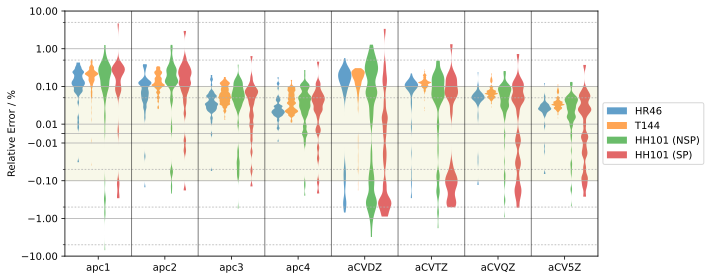

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 4), gridspec_kw={"wspace": 0}, sharey=True)

# plot

basis_list = ["apc1", "apc2", "apc3", "apc4", "aCVDZ", "aCVTZ", "aCVQZ", "aCV5Z"]
parts = [None] * len(basis_list)
parts[0] = ax.violinplot([symlog_scale(df_hr46_iso_err_dunning[(basis, "pt2")]) for basis in basis_list],
                         positions=np.arange(len(basis_list)) - 0.3, bw_method=0.1, widths=0.2, showextrema=False)
parts[1] = ax.violinplot([symlog_scale(df_t144_iso_err_dunning[(basis, "pt2")]) for basis in basis_list],
                         positions=np.arange(len(basis_list)) - 0.1, bw_method=0.1, widths=0.2, showextrema=False)
parts[2] = ax.violinplot([symlog_scale(df_hh100_iso_err_dunning.loc[~mask_hh100_sp, (basis, "pt2")]) for basis in basis_list],
                         positions=np.arange(len(basis_list)) + 0.1, bw_method=0.1, widths=0.2, showextrema=False)
parts[3] = ax.violinplot([symlog_scale(df_hh100_iso_err_dunning.loc[mask_hh100_sp, (basis, "pt2")]) for basis in basis_list],
                         positions=np.arange(len(basis_list)) + 0.3, bw_method=0.1, widths=0.2, showextrema=False)

# === configurations

for part, color in zip(parts, ["C0", "C1", "C2", "C3"]):
    for p in part["bodies"]:
        p.set_facecolor(color); p.set_alpha(0.7)

ax.set_xlim(-0.5, 7.5)
ax.set_xticks(np.arange(len(basis_list)))
ax.set_xticklabels(basis_list)

ax.set_ylim(symlog_scale(-10), symlog_scale(10))
ax.set_yticks(symlog_scale(np.array([-10, -1, -1e-1, -1e-2, 0, 1e-2, 1e-1, 1, 10])))
ax.set_yticks(symlog_scale(np.array([-5, -0.5, -0.05, 0.05, 0.5, 5])), minor=True)
ax.set_yticklabels(["$-10.00$", "$-1.00$", "$-0.10$", "$-0.01$", " ", "$0.01$", "$0.10$", "$1.00$", "$10.00$"])
ax.grid(axis="y")
ax.grid(axis="y", which="minor", dashes=(1.5, 0.5, 0.1))
ax.fill_between([-10, 100], symlog_scale([-0.1, -0.1]), symlog_scale([0.1, 0.1]), color="C8", alpha=0.1)

ax.set_ylabel("Relative Error / %")

for i in range(7):
    ax.plot([i+0.5, i+0.5], [-10, 10], color="black", alpha=0.5, linewidth=1)

parts[0]["bodies"][0].set_label("HR46")
parts[1]["bodies"][0].set_label("T144")
parts[2]["bodies"][0].set_label("HH101 (NSP)")
parts[3]["bodies"][0].set_label("HH101 (SP)")
ax.legend(loc="center left", bbox_to_anchor=(1.00, 0.5))
fig.tight_layout()
fig.savefig("../converg-b2p-pt2-aCV5Z.pdf", transparent=True)

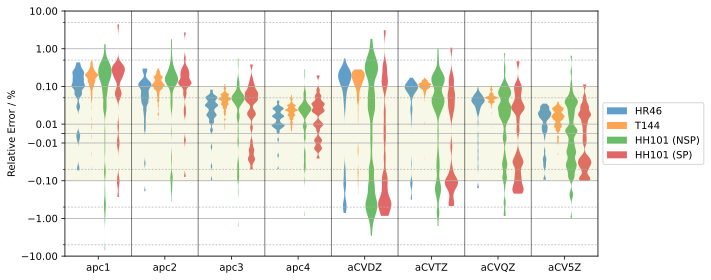

In [38]:
fig, ax = plt.subplots(1, figsize=(10, 4), gridspec_kw={"wspace": 0}, sharey=True)

# plot

basis_list = ["apc1", "apc2", "apc3", "apc4", "aCVDZ", "aCVTZ", "aCVQZ", "aCV5Z"]
parts = [None] * len(basis_list)
parts[0] = ax.violinplot([symlog_scale(df_hr46_iso_err_jensen[(basis, "pt2")]) for basis in basis_list],
                         positions=np.arange(len(basis_list)) - 0.3, bw_method=0.1, widths=0.2, showextrema=False)
parts[1] = ax.violinplot([symlog_scale(df_t144_iso_err_jensen[(basis, "pt2")]) for basis in basis_list],
                         positions=np.arange(len(basis_list)) - 0.1, bw_method=0.1, widths=0.2, showextrema=False)
parts[2] = ax.violinplot([symlog_scale(df_hh100_iso_err_jensen.loc[~mask_hh100_sp, (basis, "pt2")]) for basis in basis_list],
                         positions=np.arange(len(basis_list)) + 0.1, bw_method=0.1, widths=0.2, showextrema=False)
parts[3] = ax.violinplot([symlog_scale(df_hh100_iso_err_jensen.loc[mask_hh100_sp, (basis, "pt2")]) for basis in basis_list],
                         positions=np.arange(len(basis_list)) + 0.3, bw_method=0.1, widths=0.2, showextrema=False)

# === configurations

for part, color in zip(parts, ["C0", "C1", "C2", "C3"]):
    for p in part["bodies"]:
        p.set_facecolor(color); p.set_alpha(0.7)

ax.set_xlim(-0.5, 7.5)
ax.set_xticks(np.arange(len(basis_list)))
ax.set_xticklabels(basis_list)

ax.set_ylim(symlog_scale(-10), symlog_scale(10))
ax.set_yticks(symlog_scale(np.array([-10, -1, -1e-1, -1e-2, 0, 1e-2, 1e-1, 1, 10])))
ax.set_yticks(symlog_scale(np.array([-5, -0.5, -0.05, 0.05, 0.5, 5])), minor=True)
ax.set_yticklabels(["$-10.00$", "$-1.00$", "$-0.10$", "$-0.01$", " ", "$0.01$", "$0.10$", "$1.00$", "$10.00$"])
ax.grid(axis="y")
ax.grid(axis="y", which="minor", dashes=(1.5, 0.5, 0.1))
ax.fill_between([-10, 100], symlog_scale([-0.1, -0.1]), symlog_scale([0.1, 0.1]), color="C8", alpha=0.1)

ax.set_ylabel("Relative Error / %")

for i in range(7):
    ax.plot([i+0.5, i+0.5], [-10, 10], color="black", alpha=0.5, linewidth=1)

parts[0]["bodies"][0].set_label("HR46")
parts[1]["bodies"][0].set_label("T144")
parts[2]["bodies"][0].set_label("HH101 (NSP)")
parts[3]["bodies"][0].set_label("HH101 (SP)")
ax.legend(loc="center left", bbox_to_anchor=(1.00, 0.5))
fig.tight_layout()
fig.savefig("../converg-b2p-pt2-apc4.pdf", transparent=True)

## Analysis

In [40]:
df_hh100_iso_err_dunning["apc4"].loc[["HO2", "Na"]]

,low_rung,pt2,tot
HO2,0.199,0.025,0.224
Na,-0.154,0.453,0.300


In [59]:
for df in [df_hr46_iso, df_t144_iso, df_hh100_iso.loc[~mask_hh100_sp], df_hh100_iso.loc[mask_hh100_sp]]:
    print(get_df_err(df["aCV[Q5]Z", "low_rung"], df["apc[34]", "low_rung"], df["aCV[Q5]Z", "tot"])["RelRMSD/%"])

0.09924055178201807
0.050426318566112724
0.213921460905328
0.1353208573677784


In [60]:
for df in [df_hr46_iso, df_t144_iso, df_hh100_iso.loc[~mask_hh100_sp], df_hh100_iso.loc[mask_hh100_sp]]:
    print(get_df_err(df["aCV[Q5]Z", "pt2"], df["apc[34]", "pt2"], df["aCV[Q5]Z", "tot"])["RelRMSD/%"])

0.03360752195562416
0.03197394964443899
0.154470118767173
0.09404553277974873


In [58]:
for df in [df_hr46_iso, df_t144_iso, df_hh100_iso.loc[~mask_hh100_sp], df_hh100_iso.loc[mask_hh100_sp]]:
    print(get_df_err(df["aCV[Q5]Z", "tot"], df["apc[34]", "tot"], df["aCV[Q5]Z", "tot"])["RelRMSD/%"])

0.126640061340882
0.07961412074050896
0.28190353375914673
0.17662235100896936
